# Bayes MCMC spectral fitter: fit a line

In [1]:
import astropy.units as u
import corner
import numpy as np
from yaff import fitting, rebin_flux, plotting as yap
import scipy.stats as st

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('nice.mplstyle')

## Define fake data (counts, errors, etc) for fake spectroscopy
This data is just a line of counts made with `np.linspace`.
It is sampled as a normal distribution assuming $\sqrt N$ errors.

The response matrix starts as diagonal and then gets interpolated to allow different-sized count
vs photon energy bins. The interpolation preserves "probability flux" along the appropriate
response matrix axis.

In [2]:
# Make some fake data
cts = np.linspace(800, 3000, 5) << u.ct
cts_err = np.sqrt(cts.value) << u.ct

# Add a gaussian approximation of Poisson error onto the counts
cts = st.norm.rvs(loc=cts, scale=cts_err) << u.ct
eff_exp = 2 << u.s

count_edges = [2, 4, 6, 8, 10, 12] << u.keV
photon_edges = np.linspace(1, 50, num=40) << u.keV

# the SRM needs to get interpolated along the
# `target` aka counts axis
diag_srm = np.eye(photon_edges.size - 1)

# the rows indicate counts
# cols are photon energy bin entries
# assuming mtarix multiplication S\vec{p} = \vec{c}
# p means photon, c means model (vectors)
srm = list()
for row in diag_srm:
    interp = rebin_flux.flux_conserving_rebin(
        photon_edges, row, count_edges
    )
    srm.append(interp)


srm = np.array(srm).T << (u.ct / u.ph)
area = 1 << u.cm**2

pack = fitting.DataPacket(
    counts=cts,
    counts_error=cts_err,
    background_counts=0 * cts,
    background_counts_error=0 * cts,
    effective_exposure=eff_exp,
    count_energy_edges=count_edges,
    photon_energy_edges=photon_edges,
    response_matrix=(area * srm)
)

## Define a model to fit
Here, we just assume we're gonna fit a line, because we are.
THe model accepts a `dict` of arguments:
- Photon energy edges
- Parameters from the fitter (a `dict[str, yafp.Parameter]`)

These are used to compute the model.

Inside the model function, you can restrict or "tie" certain parameters to one another.
If you were fitting two lines and wanted to keep the intercepts the same, for instance,
this could be enforced in the model function.

The model is also just a pure Python function with very little wrapping it.
This gives flexibility to fit any kind of model you'd like.
It could even be a method bound to an instance of an object.

In [3]:
def line_model(arg_dict: dict[str, object]):
    ''' Fit a line to the data we get '''
    ph_edges: np.ndarray = arg_dict['photon_energy_edges']
    params: dict[str, fitting.Parameter] = arg_dict['parameters']

    midpoints = ph_edges[:-1] + np.diff(ph_edges)/2
    return params['intercept'].value + (params['slope'].value*midpoints)

## Probability functions: log likelihood and log priors
The next step is to define a likelihood you would like to use and enforce some prior knowledge on your parameters.

The probability function which gets sampled by `emcee` is the [(log) posterior](https://en.wikipedia.org/wiki/Posterior_probability).
We use the log of the probability so that there is more granularity in the probability fluctuations.

Here we use a $\chi^2$ log likelihood which works in a lot of cases.
You can also use a Poisson or negative binomial likelihood by using e.g.
[`st.poisson.logpdf`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.poisson.html).

In [4]:
def log_likelihood(data: fitting.DataPacket, model: np.ndarray):
    '''Basic chi2 log likelihood'''
    return -np.nan_to_num((data.counts - model)**2 / data.counts_error**2).sum()


# Define the model parameters we want to use
params = {
    'slope': fitting.Parameter(-10 << u.ph / u.keV, frozen=False),
    'intercept': fitting.Parameter(3000 << u.ph, frozen=False)
}

# Define the priors on those parameters (uniform from -1000 to 1000 for each)
log_priors = {
    'slope': fitting.simple_bounds(-10000, 10000),
    'intercept': fitting.simple_bounds(-10000, 10000),
}

## Actual fitting: make sure stuff works
Now that the mathematics defining the model have been set up, fitting is straightforward.
The fitter coordinates parameter variations and basic `emcee.EnsembleSampler` management.
It also facilitates easy conversion from a photon to count model.



In [5]:
fitter = fitting.BayesFitter(
    data=pack,
    model_function=line_model,
    parameters=params,
    log_priors=log_priors,
    log_likelihood=log_likelihood
)

In [6]:
# Look at the parameters to check if they're in good shape
fitter.parameters

OrderedDict([('slope', Parameter(-1.00e+01, ph / keV, frozen=False)),
             ('intercept', Parameter(3.00e+03, ph, frozen=False))])

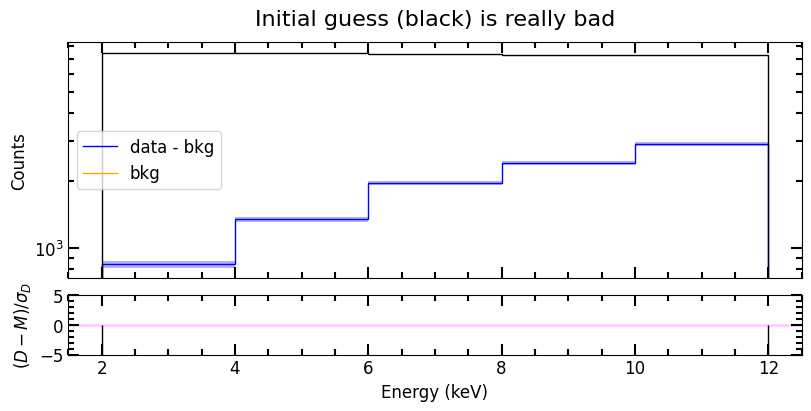

In [7]:
ret = yap.plot_data_model(fitter, model_samples=[fitter.eval_model()])
ret['error_ax'].set(xscale='linear', yscale='linear')
ret['data_ax'].set(title='Initial guess (black) is really bad')
plt.show()

## To get us closer to the "best parameters" use Levenberg-Marquadt minimization like XSPEC

In [8]:
# Get an "OK" minimized answer using Levenberg-Marquadt
fitter = fitting.levenberg_minimize(fitter)
fitter.parameters

OrderedDict([('slope', Parameter(1.04e+02, ph / keV, frozen=False)),
             ('intercept', Parameter(2.32e+01, ph, frozen=False))])

In [9]:
# Finally, perform the fit and give emcee some kwargs if you want
fitter.run_emcee(
    emcee_constructor_kw=dict(),
    emcee_run_kw=dict(nsteps=5000, progress=True)
)

# Optionally save the fit result to a compressed pickle file
# fitter.save('test.pkl.xz', open_func=lzma.open)

100%|██████████| 5000/5000 [00:07<00:00, 702.52it/s]


## Diagnostics: autocorrelation and MCMC chains
It's always a good idea to make sure your fit has "enough" samples; this can be assessed by looking at the autocorrelation time of the parameter chains.

Oftentimes in X-ray spectroscopy the autocorrelation time is very long because the parameters are strongly correlated. It is not always possible to make `emcee` happy, but it's good to check.

In [10]:
# No error thrown means that the autocorrelation time is much shorter
# than the MCMC chain length
print('autocorrelation times:', fitter.emcee_sampler.get_autocorr_time())
slope_chain, inter_chain = fitter.emcee_sampler.flatchain.T

autocorrelation times: [28.6817655 29.1609803]


{'fig': <Figure size 800x800 with 2 Axes>,
 'axes': [<Axes: title={'center': 'slope'}, ylabel='ph / keV'>,
  <Axes: title={'center': 'intercept'}, ylabel='ph'>]}

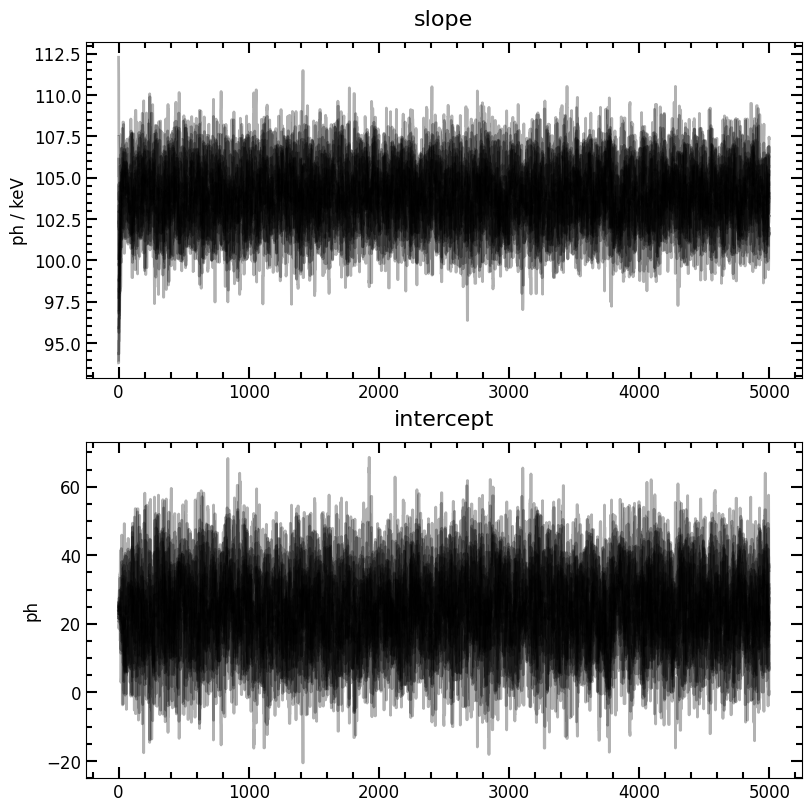

In [11]:
# Plot the chains to see how well things converged
fig = plt.figure(figsize=(8, 8))
yap.plot_parameter_chains(fitter, names=fitter.free_param_names, params=list(fitter.free_parameters.values()), fig=fig)

## Now, plot some sample models over the data

{'fig': <Figure size 800x600 with 2 Axes>,
 'data_ax': <Axes: title={'center': 'Model vs Data'}, ylabel='Counts'>,
 'error_ax': <Axes: xlabel='Energy (keV)', ylabel='$(D - M) / \\sigma_D$'>}

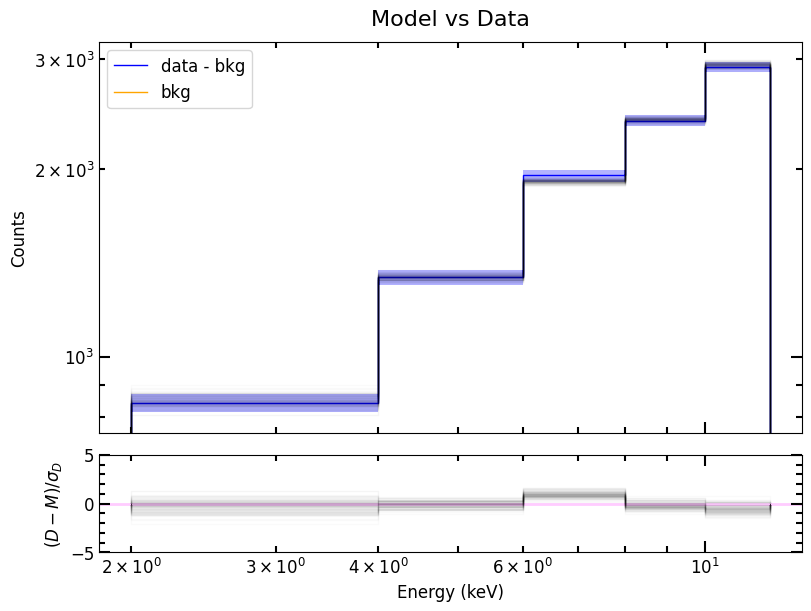

In [12]:
fig = plt.figure(figsize=(8, 6))
models = fitter.generate_model_samples(num=100)
yap.plot_data_model(fitter, models, fig=fig)

## Finally, make a corner plot of the MCMC sampled parameters

/home/william/dev/yaff/.venv/lib/python3.13/site-packages/corner/core.py:133: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(


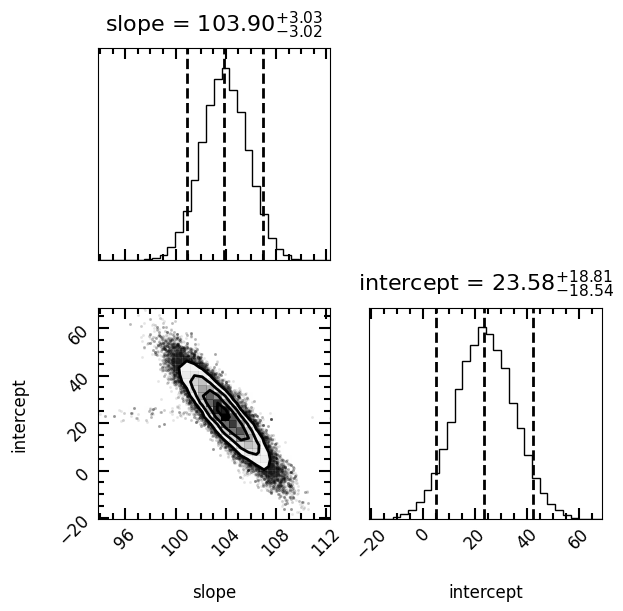

In [13]:
flat = fitter.emcee_sampler.flatchain
names = fitter.free_param_names


fig = plt.figure(figsize=(6, 6))
corner.corner(
    flat,
    bins=30,
    labels=names,
    quantiles=(0.05, 0.5, 0.95),
    show_titles=True,
    fig=fig
)
None

### Interestingly the slope and intercept are strongly negatively correlated. Also the intercept has a very large uncertainty associated with it. Perhaps if we had more count bins, this wouldn't be the case. In any event, the slope uncertainty is small.